In [1]:
import os
import re

import numpy as np
import jax
import jax.numpy as jnp
import tensorflow as tf
import matplotlib.pyplot as plt

import ml_collections

from molnet.data import input_pipeline
from configs import root_dirs
from configs.tests import attention_test

In [2]:
config = attention_test.get_config()
config.root_dir = root_dirs.get_root_dir()
config.num_workers = 8

In [ ]:
rng = jax.random.PRNGKey(0)
datasets = input_pipeline.get_datasets(config)

ds = iter(datasets['val'])
batch = next(ds)

batch = {
    "images": batch[0],
    "atom_map": batch[1],
    "xyz": batch[2],
}

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 8426222558766033084
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 2366137671365574134
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing te

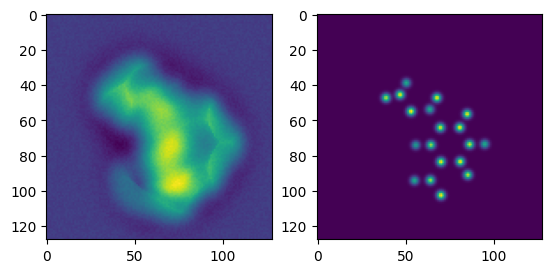

In [10]:
x = batch['images'][0]
preds_z = x.shape[-2]
y = batch['atom_map'][0]
y = y[..., -preds_z:, :]

ax = plt.subplot(1, 2, 1)
plt.imshow(x[..., -1, 0])

ax = plt.subplot(1, 2, 2)
plt.imshow(y.mean(axis=(-1, -2)))

## Create "fake" webdataset for testing

In [15]:
import webdataset as wds

In [21]:
def generator(N=100):
    for i in range(N):
        sample = {
            "__key__": str(i*100),
            "label.cls": i*100,
        }
        yield sample

In [22]:
temp_outputdir = "./temp/shard_1.tar"

os.makedirs(os.path.dirname(temp_outputdir), exist_ok=True)

gen = generator(100)
with wds.TarWriter(temp_outputdir) as sink:
    for sample in gen:
        sink.write(sample)

In [117]:
shardlist = [
    os.path.join("./temp", shard) for shard in os.listdir("./temp")
]
ds = wds.DataPipeline(
    wds.SimpleShardList(shardlist),

    wds.shuffle(100),

    wds.tarfile_to_samples(),

    wds.shuffle(1000),

    wds.decode("l"),

    wds.to_tuple("__key__", "label.cls"),

    wds.batched(16)
)

In [124]:
loader = iter(ds)
end_after_this_iteration = False

for i in range(1000):
    try:
        batch = next(loader)
    except StopIteration:
        if end_after_this_iteration:
            break
        print()

        loader = iter(ds)
        end_after_this_iteration = True
        continue

    print(batch[0])

['8900', '2100', '2000', '7300', '1', '6000', '6700', '400', '2800', '3', '1000', '12', '10', '7600', '2500', '27']
['3000', '6600', '22', '2300', '23', '31', '5600', '15', '24', '7700', '9100', '9', '7000', '18', '7800', '9500']
['1900', '46', '66', '3300', '62', '11', '72', '71', '36', '6800', '57', '33', '4600', '7', '4400', '8100']
['9800', '14', '8800', '5700', '1800', '3700', '47', '2600', '600', '6100', '2700', '21', '97', '43', '68', '7200']
['5800', '800', '3900', '8400', '80', '1600', '83', '51', '37', '7400', '6900', '1700', '4900', '87', '1300', '63']
['4300', '30', '9200', '2', '94', '9000', '8700', '95', '52', '7100', '2900', '38', '4', '300', '3600', '73']
['1200', '45', '6200', '100', '39', '49', '13', '4200', '65', '2200', '4500', '85', '5', '7900', '40', '8200']
['86', '9600', '61', '55', '4700', '89', '8600', '19', '76', '77', '3100', '75', '17', '48', '4000', '9900']
['6500', '5200', '8500', '4800', '29', '5900', '69', '34', '3200', '32', '58', '70', '7500', '0', '3

## data augmentation

In [2]:
def plot_stack(x):
    xmax = tf.reduce_max(x).numpy()
    fig, ax = plt.subplots(1, 5)
    for i in range(5):
        ax[i].imshow(x[..., i, 0], vmin=0, vmax=xmax)

In [6]:
x = np.arange(128)
y = np.arange(128)

x, y = np.meshgrid(x, y)
z = x + y
z = z[..., None]
z = np.tile(z, (1, 1, 5))

z2 = x * y
z2 = z2[None, ..., None]
z2 = np.tile(z2, (5, 1, 1, 20))

orig_batch = {
    "images": z,
    "atom_map": z2,
    "xyz": np.zeros((5, 20, 3)),
}

print(orig_batch['images'].shape)
print(orig_batch['atom_map'].shape)

(128, 128, 5)
(5, 128, 128, 20)


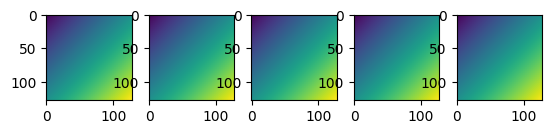

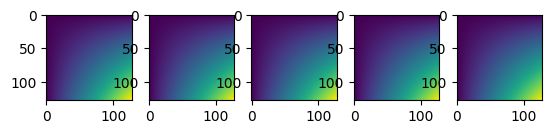

In [7]:
fig, ax = plt.subplots(1, 5)
for i in range(5):
    ax[i].imshow(z[..., i])

fig, ax = plt.subplots(1, 5)
for i in range(5):
    ax[i].imshow(z2[i, ..., 0])

In [16]:
print(orig_batch['images'].shape)

batch = input_pipeline._preprocess_images(
    orig_batch,
    noise_std=0.1,
    interpolate_z=16,
    cutout_probs=[0.5, 0.3, 0.1, 0.05, 0.5],
)

print(orig_batch['images'].shape)

print(batch['images'].shape)
print(batch['atom_map'].shape)

(128, 128, 5)
(128, 128, 5)
(128, 128, 16, 1)
(128, 128, 16, 5)


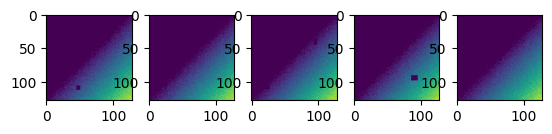

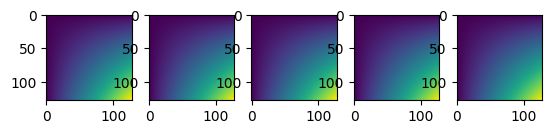

In [17]:
plot_stack(batch['images'])
plot_stack(batch['atom_map'])